In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## Extract somno scoring and state probabilities

def load_data_probs(subject_id):
    somno_scoring = pd.read_csv(input(f"Enter location of file for {subject_id} of the somnotate scoring converted back to CSV: "))
    state_probabilities =  np.load(input(f"Enter location of file for {subject_id} of the state probabilities npz file: "))
    return somno_scoring, state_probabilities

# Load data for subjects
#somno_scoring_sub_007, state_probabilites_sub_007 = load_data_probs("sub-007")
somno_scoring_sub_010, state_probabilites_sub_010 = load_data_probs("sub-010")
#somno_scoring_sub_011, state_probabilites_sub_011 = load_data_probs("sub-011")

In [6]:
# Extract entries from state probabilities in different stages

def extract_from_npzfile(npzfile, keys):
    """
    Extract specified keys from an npzfile object into individual arrays.

    Parameters:
        npzfile (NpzFile): The npzfile object loaded via np.load.
        keys (list): List of keys to extract from the npzfile.

    Returns:
        dict: A dictionary where each key corresponds to its extracted array.
    """
    extracted_data = {}
    for key in keys:
        if key in npzfile.keys():
            extracted_data[key] = npzfile[key]
        else:
            print(f"Warning: Key '{key}' not found in the npzfile.")
    return extracted_data

# Example usage
keys = ['awake', 'non-REM', 'REM']
npzfile = state_probabilites_sub_010  # Assuming you have already loaded it
extracted_data = extract_from_npzfile(npzfile, keys)

# Access data for each key
awake_data = extracted_data.get('awake')
non_rem_data = extracted_data.get('non-REM')
rem_data = extracted_data.get('REM')


In [ ]:
# Function to assist in determining range of values which may be of interest for plotting due to likelihood values

def find_first_n_instances_below_after_above(awake_data, threshold, n=10):
    """
    Finds the first N instances where awake_data drops below the threshold after going above it.

    Parameters:
        awake_data (array-like): The awake data to analyze.
        threshold (float): The threshold value to check against.
        n (int): Number of instances to find.

    Returns:
        list: A list of tuples (start_index, end_index) for each instance.
    """
    instances = []
    above = False
    start_index = -1

    for i, value in enumerate(awake_data):
        if value > threshold:
            above = True
            start_index = i
        elif above and value < threshold:
            instances.append((start_index, i))
            above = False  # Reset for the next instance

            # Stop once we've found N instances
            if len(instances) >= n:
                break

    return instances

# Example usage
if awake_data is not None:
    threshold = 0.75
    n = 10
    result = find_first_n_instances_below_after_above(awake_data, threshold, n)

    if result:
        for idx, (start, end) in enumerate(result):
            print(f"Instance {idx + 1}: Awake data drops below {threshold} after exceeding it, between indices {start} and {end}.")
    else:
        print(f"No instances found where awake data drops below {threshold} after exceeding it.")


Instance 1: Awake data drops below 0.75 after exceeding it, between indices 38 and 39.
Instance 2: Awake data drops below 0.75 after exceeding it, between indices 4523 and 4524.
Instance 3: Awake data drops below 0.75 after exceeding it, between indices 4564 and 4565.
Instance 4: Awake data drops below 0.75 after exceeding it, between indices 4987 and 4988.
Instance 5: Awake data drops below 0.75 after exceeding it, between indices 5729 and 5730.
Instance 6: Awake data drops below 0.75 after exceeding it, between indices 5753 and 5754.
Instance 7: Awake data drops below 0.75 after exceeding it, between indices 5834 and 5835.
Instance 8: Awake data drops below 0.75 after exceeding it, between indices 7203 and 7204.
Instance 9: Awake data drops below 0.75 after exceeding it, between indices 7555 and 7556.
Instance 10: Awake data drops below 0.75 after exceeding it, between indices 7989 and 7990.


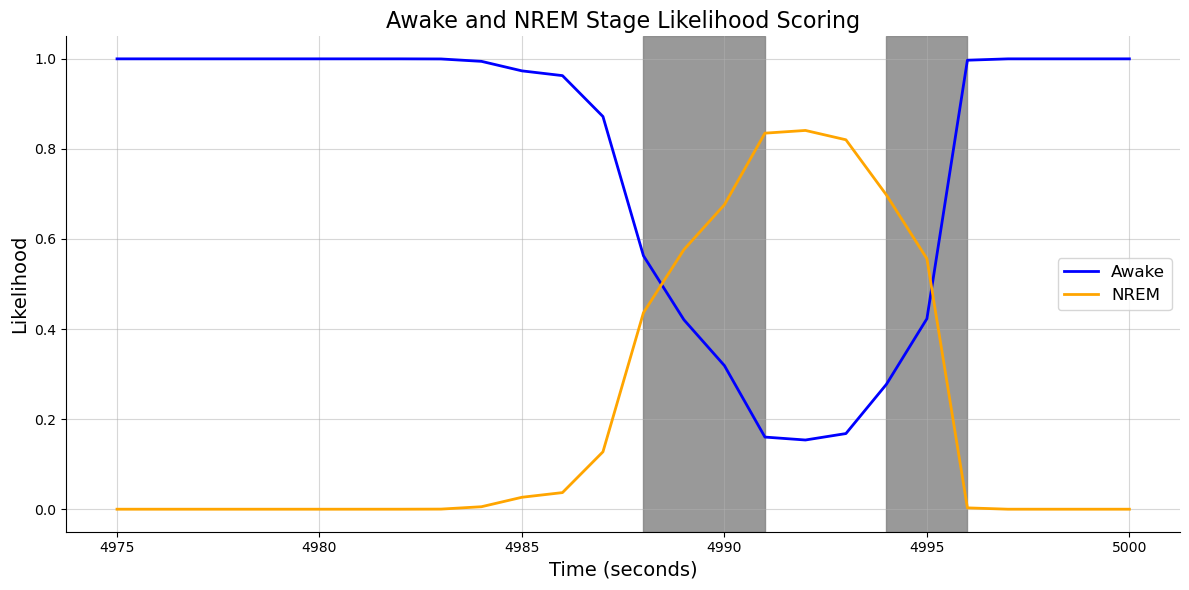

Shaded indices: [(4988, 4991), (4994, 4996)]


In [ ]:
# Ploting the somnotate likelihood scores and returning values where likelihood is between 0.2-0.8 for matching in EEG plot

def plot_awake_and_non_rem(awake_data, non_rem_data, start_idx, end_idx):
    """
    Plot awake_data and non_rem_data values between specified indices,
    and return the indices where awake_data values fall between 0.2 and 0.8.

    Parameters:
        awake_data (array-like): Array of awake data values.
        non_rem_data (array-like): Array of non-REM data values.
        start_idx (int): Start index for the range to plot.
        end_idx (int): End index for the range to plot.

    Returns:
        shaded_indices (list of tuples): List of index ranges that satisfy the shading condition.
    """
    # Slice the data to the specified range
    x = range(start_idx, end_idx + 1)
    awake_values = awake_data[start_idx:end_idx + 1]
    non_rem_values = non_rem_data[start_idx:end_idx + 1]

    # Identify indices where the awake_values satisfy the condition (0.2 < value < 0.8)
    shaded_indices = []
    in_shaded_region = False
    for i, value in enumerate(awake_values):
        if 0.2 < value < 0.8:
            if not in_shaded_region:
                # Start of a new shaded region
                in_shaded_region = True
                region_start = i
        else:
            if in_shaded_region:
                # End of a shaded region
                in_shaded_region = False
                region_end = i
                shaded_indices.append((start_idx + region_start, start_idx + region_end))
    
    # Handle case if the shaded region goes till the end of the data
    if in_shaded_region:
        shaded_indices.append((start_idx + region_start, end_idx))

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(x, awake_values, label='Awake', color='blue', linewidth=2)
    plt.plot(x, non_rem_values, label='NREM', color='orange', linewidth=2)

    # Shade the regions that satisfy the condition
    for region in shaded_indices:
        plt.axvspan(region[0], region[1], color='gray', alpha=0.8)

    # Customize the plot
    plt.title(f'Awake and NREM Stage Likelihood Scoring', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=14)
    plt.ylabel('Likelihood', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Return the indices
    return shaded_indices


# Example usage
shaded_indices = plot_awake_and_non_rem(awake_data, non_rem_data, start_idx=4975, end_idx=5000)

# Output the shaded indices
print("Shaded indices:", shaded_indices)
